<a href="https://colab.research.google.com/github/ccnmagnoo/colabs/blob/main/genderizer_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Model for name Gender analizer.
## using tensorflow

Version 2,
- restricted just single chart analizer.
- restricted char list key normalizer.
- input size restricter to 20 string size
- keras includes RELU transform.
400 epocs, and 95% accuracy, but must be at least 99%,
probably requires a bigger source for modeling,

In [ ]:
import json
import urllib
import requests
import numpy as np
import tensorflow as tf

# Loading Data

In [ ]:
#Fetching data

##Conecction
headers = {
    'X-Parse-Application-Id': 'zsSkPsDYTc2hmphLjjs9hz2Q3EXmnSxUyXnouj1I', # This is the fake app's application id
    'X-Parse-Master-Key': '4LuCXgPPXXO2sU5cXm6WwpwzaKyZpo3Wpj4G4xXK' # This is the fake app's readonly master key
}

def fetchUrl(skip:int,limit:int):
  url ='https://parseapi.back4app.com/classes/NamesList?skip='+ str(skip)+'&limit='+ str(limit)+'&order=Name&excludeKeys=Letter'
  data = json.loads(requests.get(url, headers=headers).content.decode('utf-8')) # Here you have the data that you need
  return data['results']

##Creating skip walkpath
step=100 # @param {type:"number"}
limit=6000 # @param {type:"number"}
walkpath = np.array(range(0,limit,step))
## mapping fetching
data = np.array(list(map(fetchUrl,walkpath,[limit]))).flatten()

##fetching names
nameList = list(map(lambda item:item['Name'],data))
genderList = list(map(lambda item:item['Genre'],data))
print(f"number of names in source database: {len(nameList)}")

number of names in source database: 6000


## Pre-procesing data

In [ ]:
from typing_extensions import LiteralString
from typing import Union, List
##Normalizing list for Machine Learning with values between 0 and 1

###Genre
def genreNormalizer(genre:str)->int:
  if genre == 'female':
    x = 1
  else:
    x = 0
  return x

genderTensorList = list(map(genreNormalizer,genderList))

###Names
#return array float size 20
CHARS:List[str] = list('aábcdeéfghiíjklmnñoópqrstuúvwxyz ')

BOX_SIZE = 20 # @param {type:"slider", min:20, max:40, step:1}
def nameNormalizer(name:str)->List[float]:
  splitedName = list(name.lower()) # Carlos -> [c,a,r,l,o,s]
  descriteName = list(map(lambda char:CHARS.index(char)/len(CHARS),splitedName)) #[c,a,r,l,o,s]->[3,1,..] indexation
  box = [0.0]*(BOX_SIZE-len(descriteName)) # content into a 20 size box [0.0 ,0.0 ..,3,1,..]
  input = np.concatenate((np.array(box),np.array(descriteName)))
  return list(input.flatten())

nameTensorList = list(map(nameNormalizer,nameList))

## Config Neuronal Nextwork


In [ ]:
# @title model configuration
model = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(BOX_SIZE,1)),
  tf.keras.layers.Dense(80,activation='relu'),
  tf.keras.layers.Dense(80,activation='relu'),
  tf.keras.layers.Dense(80,activation='relu'),
  tf.keras.layers.Dense(2,activation='softmax'),
])

In [ ]:
#model compiling
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


In [ ]:
# @title Training model
EPOCHS = 400 # @param {type:"slider", min:100, max:400, step:25}
modeling = model.fit(nameTensorList,genderTensorList,epochs=400,verbose=False)

188/188 - 0s - loss: 0.1202 - accuracy: 0.9562 - 399ms/epoch - 2ms/step

Test accuracy: 0.956166684627533


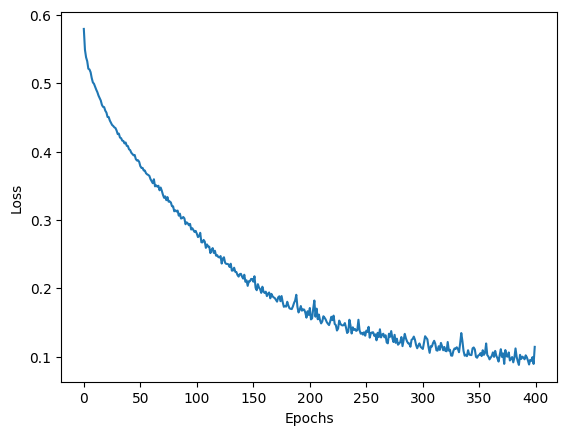

In [ ]:
import matplotlib.pyplot as plt
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(modeling.history['loss'])

test_loss, test_acc = model.evaluate(nameTensorList,  genderTensorList, verbose=2)

print('\nTest accuracy:', test_acc)

In [ ]:
# Unit test
def genderProbability(name:str):
  gender = ['male','female']
  input = nameNormalizer(name)
  prediction = model.predict([input])[0]
  category = gender[np.argmax(prediction)]

  return (category,str(round(np.max(prediction)*100,2))+'%')

print(genderProbability('Melanie'))

1/1 [==============================] - 0s 147ms/step
('female', '99.99%')


In [ ]:
# @title store h5 keras model
# @markdown select output h5 filename
FILENAME = 'keras_genderizer_model_v2' # @param {type:"string"}
keras_model_path = f'/content/drive/MyDrive/MinEnergia/99.Data/GenderEquality/{FILENAME}.h5'
model.save(keras_model_path)
# to reload your model
#model = keras.models.load_model(saved_model_path)